First, we'll obtain the single-peak Gaussian signals that we randomly generated. This will be the simplest test case for this RNN method, and we'll build the complexity from here.

In [98]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np

In [99]:
path = 'saved_data/math_functions_single.nc'

# Load .nc file
ds = xr.open_dataset(path)

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
x = ds["x"].values

Visualize some of the randomly generated Gaussian signals with single peaks.

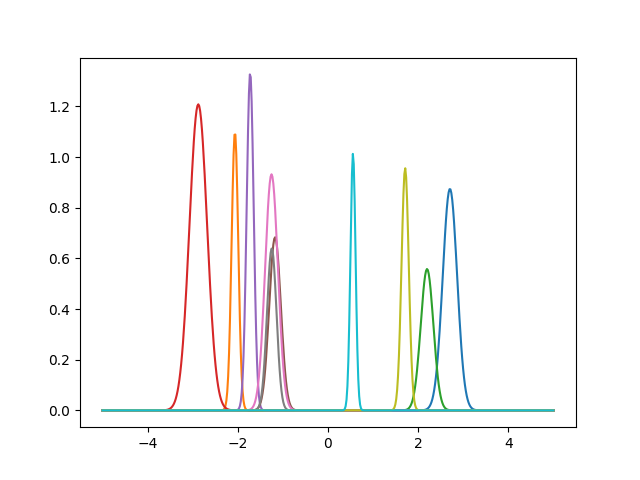

In [100]:
plt.figure()

for i in range(10):
    plt.plot(x, gaussians[i])

In [101]:
import torch
import torch.nn as nn

In [102]:
sequence_length = 500 # num of x values
input_size = 2 # 2 because we have (x, intensity) coordinates, which are 2 features

# input shape should be: (batch_size, sequence_length, input_size)
batch_size = 5 # can make batch size = 5?

In [104]:
class PeakFinderRNN(nn.Module):
    def __init__(self, input_size=500, hidden_size=64, output_size=1):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # output_size=1 for peak position regression
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, (hn, cn) = self.rnn(x)
        # hn shape: (num_layers * num_directions, batch, hidden_size)
        hn = hn[-1]  # Take the last layer's hidden state
        out = self.fc(hn)  # Predict peak position
        return out.squeeze(-1)  # shape: (batch,)

In [105]:
i = 1
peak_idx = gaussians[i].argmax()
peak_x = x[peak_idx]

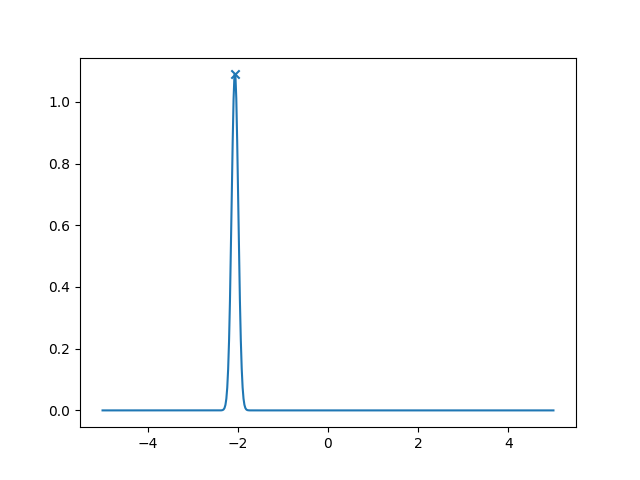

In [106]:
peak_idx
plt.figure()
plt.scatter(peak_x, gaussians[i][peak_idx], marker='x')
plt.plot(x, gaussians[i])

In [107]:
import torch.optim as optim

In [108]:
total_num = gaussians.shape[0]

all_x_arrs = []
for _ in range(total_num):
    all_x_arrs.append(x)

all_xs = np.stack(all_x_arrs, axis=0)
all_xs.shape

(10000, 500)

In [109]:
sequence_length = gaussians.shape[1]

idx_1 = int(total_num*0.6)
idx_2 = int(total_num*0.8)

train_x = torch.from_numpy(all_xs[0 : idx_1])
train_gauss = torch.from_numpy(gaussians[0 : idx_1])

val_x = torch.from_numpy(all_xs[idx_1 : idx_2])
val_gauss = torch.from_numpy(gaussians[idx_1 : idx_2])

test_x = torch.from_numpy(all_xs[idx_2 : ])
test_gauss = torch.from_numpy(gaussians[idx_2 : ])

In [110]:
all_xs.shape

(10000, 500)

In [111]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

torch.Size([6000, 500])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([6000, 500])
torch.Size([2000, 500])
torch.Size([2000, 500])


In [112]:
from torch.utils.data import DataLoader, TensorDataset

train_x = train_x.float()
val_x = val_x.float()
test_x = test_x.float()

In [113]:
train_gauss = train_gauss.float()
val_gauss = val_gauss.float()
test_gauss = test_gauss.float()

In [114]:
train_ds = TensorDataset(train_x, train_gauss)
val_ds = TensorDataset(val_x, val_gauss)
test_ds = TensorDataset(test_x, test_gauss)

In [115]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [127]:
model = PeakFinderRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [128]:
for epoch in range(20):
    model.train()
    train_loss = 0
    
    for x, y in train_loader:
        pred_y = model(x)
        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print(loss.item())
print()
model.eval()
total_loss = 0
with torch.no_grad():
    for xval, yval in val_loader:
        pred_yval = model(xval)
        loss = criterion(pred_yval, yval)
        total_loss += loss.item()
        print(loss.item())

/nsls2/users/shasko/conda_envs/internship/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5, 500])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.1415555775165558
0.05166896805167198
0.035865336656570435
0.028735488653182983
0.01658358983695507
0.020407259464263916
0.016706328839063644
0.018200641497969627
0.01691250689327717
0.016596445813775063
0.02208377979695797
0.016125358641147614
0.03279738873243332
0.022585421800613403
0.019994564354419708
0.019763357937335968
0.03518958017230034
0.03564508259296417
0.03708032891154289
0.007051032967865467
0.018693337216973305
0.023665616288781166
0.013231036253273487
0.01676308549940586
0.014712437056005001
0.021553393453359604
0.041670914739370346
0.027682511135935783
0.01604442298412323
0.03445373848080635
0.02730444259941578
0.02613159827888012
0.026725171133875847
0.03736257180571556
0.030830463394522667
0.02589935064315796
0.028971927240490913
0.01676432602107525
0.022227520123124123
0.017976880073547363
0.020645374432206154
0.02280985377728939
0.01778651587665081
0.02556680329144001
0.011543107219040394
0.03480781987309456
0.010582365095615387
0.03644995763897896
0.0219642203301

In [120]:
total_loss

9.396122458390892